### Make initial conditions for present day experiment

Based on observations from B-SOSE (http://sose.ucsd.edu/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import gsw
import tqdm
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.interpolation import interp_latlon_cf, neighbours, neighbours_z, extend_into_mask
from nemo_python.utils import fix_lon_range

In [2]:
# File locations on Jasmin:
folder_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
folder_BC   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/'
folder_NEMO = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'

# Load files:
nemo = xr.open_dataset(f'{folder_NEMO}coordinates_AIS.nc').squeeze()
nemo_mask = xr.open_dataset(f'{folder_NEMO}mesh_mask-20231025.nc')
sose      = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m01.nc')
domcfg    = xr.open_dataset(f'{folder_NEMO}domain_cfg-20231025.nc')

nemo_depths = nemo_mask.nav_lev.values

#### Functions

In [3]:
# Compute edges of the z-levels
def vertical_edges(mesh, mtype='nemo'):

    if mtype=='nemo':    # 2D
        z_centres = mesh.gdept_0.isel(time_counter=0).values
        dz        = mesh.e3t_0.isel(time_counter=0).values
    elif mtype=='SOSE':  # 1D --> 2D
        z_centres, _ = xr.broadcast(-1*sose.Z, mesh[list(mesh.keys())[0]].isel(z=0))
        dz, _        = xr.broadcast(sose.drF, mesh[list(mesh.keys())[0]].isel(z=0))
        
        z_centres = z_centres.values
        dz        = dz.values
    else:
        print('Only mesh types included are nemo and SOSE')

    z_top_edge = z_centres - 0.5*dz
    z_bot_edge = z_centres + 0.5*dz
    
    z_top_edge[z_top_edge < 0] = 0
    
    return (z_top_edge, z_centres, z_bot_edge)

In [32]:
# Helper function to convert an xarray dataset with 3D T and S to TEOS10
# - inputs: practical salinity and potential temperature
# - returns: absolute salinity and conservative temperature
def convert_to_teos10(dataset, var='SALT'):
    # Convert to TEOS10

    # Need 3D lat, lon, pressure at every point, so if 1D or 2D, broadcast to 3D
    if dataset.lon.values.ndim <= 2:
        lon   = xr.broadcast(dataset['lon'], dataset['potT'])[0]
    if dataset.lat.values.ndim <= 2:
        lat   = xr.broadcast(dataset['lat'], dataset['potT'])[0]
    if dataset.depth.values.ndim <= 2:
        # Need pressure in dbar at every 3D point: approx depth in m
        press = np.abs(xr.broadcast(dataset['depth'], dataset['potT'])[0])
    else:
        press = np.abs(dataset['depth'])
    
    if var=='SALT':
        # Get absolute salinity
        absS  = gsw.SA_from_SP(dataset['pracS'], press, lon, lat)

        return absS
    elif var=='THETA':    
        # Get absolute salinity
        absS  = gsw.SA_from_SP(dataset['pracS'], press, lon, lat)
        # Get conservative temperature
        consT  = gsw.CT_from_t(absS, dataset['potT'], press)
        
        return consT
    else:
        raise Exception('Variable options are SALT or THETA')

In [33]:
def IC_horizontal_interp(dataset='SOSE', 
                         in_file='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc',
                         salt_file='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc',
                         coordinates_file='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/coordinates_AIS.nc',
                         out_file='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SALT-horizontal-interp.nc'):
    
    # Load files:
    nemo   = xr.open_dataset(f'{coordinates_file}').squeeze()
    source = xr.open_dataset(f'{in_file}')
    
    print(f'Horizontally interpolating each depth level in {dataset} dataset to NEMO grid')
    datasets = []
    # Loop over all source dataset depth levels:
    for dl in tqdm(range(source.Z.size)):
        if dataset == 'SOSE':
            name_remapping = {'XC':'lon', 'YC':'lat', 'Z':'depth'}
                
            # Read variable and slice to the latitude range of interest to reduce size
            SOSE_var = xr.open_dataset(f'{in_file}').rename(name_remapping).sel(lat=slice(-90, -48))
            # Convert longitudes from 0-360 to -180 to 180 
            SOSE_var['lon'] = fix_lon_range(SOSE_var.lon)
            SOSE_var        = SOSE_var.sortby('lon') 
    
            # convert temperature and salinity values to TEOS10:
            print('Converting variable to TEOS10')
            if list(SOSE_var.keys())[0] == 'SALT':
                SOSE = xr.Dataset({'lon':SOSE_var['lon'], 'lat':SOSE_var['lat'], 'depth': SOSE_var['depth'],
                                   'potT':SOSE_var['SALT'], 'pracS':SOSE_var['SALT']})
                
            elif list(SOSE_var.keys())[0] == 'THETA':
                print('Note: to convert potential temperature to conservative temperature, TEOS10 uses absolute salinity. Make sure correct salinity file is specified.')
                SOSE_salt        = xr.open_dataset(f'{salt_file}').rename(name_remapping).sel(lat=slice(-90, -48))    
                SOSE_salt['lon'] = fix_lon_range(SOSE_salt.lon)
                SOSE_salt        = SOSE_salt.sortby('lon') 
                SOSE             = xr.Dataset({'lon':SOSE_var['lon'], 'lat':SOSE_var['lat'], 'depth': SOSE_var['depth'],
                                               'potT':SOSE_var['THETA'], 'pracS':SOSE_salt['SALT']})
            
            SOSE_converted   = convert_to_teos10(SOSE, var=list(SOSE_var.keys())[0])

            # Mask values that are on land in the source dataset
            var_source = xr.where(SOSE_var.maskC.isel(depth=dl)==1, SOSE_converted.isel(depth=dl), np.nan)
            var_source = xr.where(var_source==0, np.nan, var_source)
            # Now wrap up into a new Dataset
            source = xr.Dataset({'lon':SOSE['lon'], 'lat':SOSE['lat'], list(SOSE_var.keys())[0]:var_source}) 
            
            # Interpolate slices of depth levels along lat-lon (horizontally)
            interp_src = interp_latlon_cf(source, nemo, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
            
            datasets.append(interp_src)
    
    source_interpolated = xr.concat(datasets, dim='z').assign_coords(z=np.abs(source.Z.values[0:dl+1]))
    source_interpolated.to_netcdf(f'{out_file}')
    
    return

In [11]:
def interp_depth(source, source_edges, nemo_edges, n):
    # For a particular input nemo depth level, interpolate from source grid to nemo grid (conservatively nearest-neighbour)
    
    NEMO_top_edge = nemo_edges[0][n,:,:]; NEMO_bot_edge = nemo_edges[2][n,:,:];

    dataset = xr.Dataset({}) #.assign_coords(x=source.x, y=source.y)

    for var in source: # loop over the variables in the source dataset
        # find the source edges that fall within the depth ranges of the NEMO grid cells:
        Var = 0; 
        for zs in range(0,source.z.size):
            src_top_edge = source_edges[0][zs,:,:]; src_bot_edge = source_edges[2][zs,:,:];

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                           Var + (NEMO_bot_edge - NEMO_top_edge)* (source.isel(z=zs)), Var)

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                           Var + (src_bot_edge - NEMO_top_edge) * source.isel(z=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (NEMO_bot_edge - src_top_edge) * source.isel(z=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (src_bot_edge - src_top_edge) * source.isel(z=zs), Var)

            # if the SOSE bottom grid cell is shallower than the WOA bottom grid cell, the value of the cell is NaN
        
        Var = Var/(NEMO_bot_edge - NEMO_top_edge)
        dataset[var] = (('y', 'x'), Var[var].values)
        
    return dataset

## Main

In [6]:
# if dataset[var].values.ndim <= 2:

# else: # will need to loop over depths since 
    

In [20]:
SOSE_hinterp_salt = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/salt-horizontal-interp.nc')

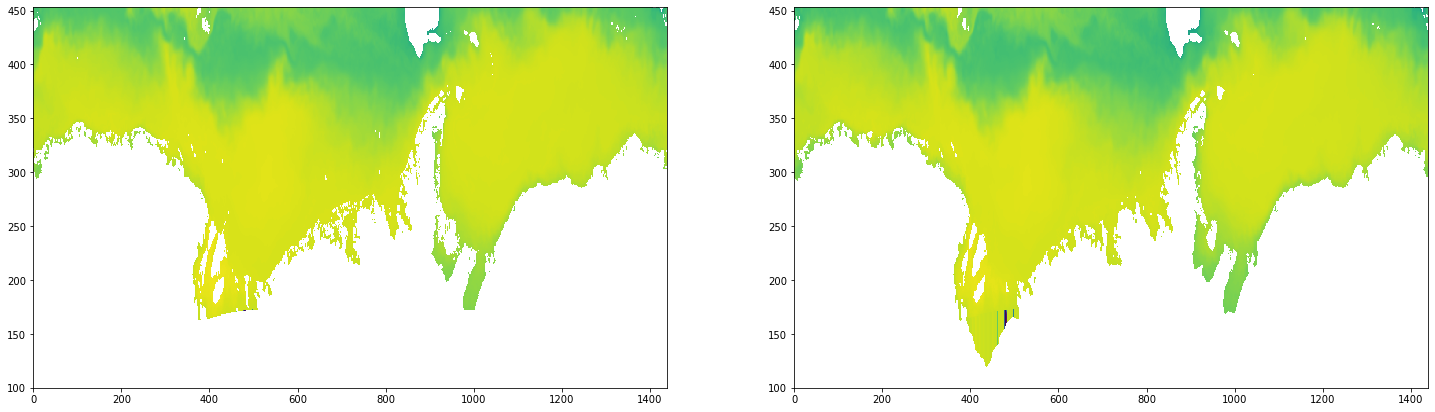

In [73]:
int=28
vminm=33
vmaxm=35
fig, ax = plt.subplots(1,2, figsize=(25,7))
ax[0].pcolormesh(SOSE_hinterp_salt.SALT.isel(z=int).values, vmin=vminm, vmax=vmaxm)
# ax[1].pcolormesh(theta_extended[45,:,:], vmin=vminm, vmax=vmaxm)

for axis in ax.ravel():
    axis.set_ylim(100,453)

In [ ]:
def vertical_interp(hinterp_var, dataset='SOSE', folder_ICs='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/'):
    # hinterp_var : horizontally interpolated variable
    nemo_edges   = vertical_edges(nemo_mask, mtype='nemo')
    source_edges = vertical_edges(hinterp_var, mtype=dataset)    
    
    print(f'Vertically interpolating variable {list(file_interp.keys())[0]}')
    model_ICs = []
    for n in tqdm.tqdm(range(len(nemo_mask.nav_lev.values))): 
        # Interpolate slices from SOSE to NEMO depth levels
        data_interp = interp_depth(hinterp_var, source_edges, nemo_edges, n)
        # Add interpolated layers to dataset
        model_ICs.append(data_interp)
    
    source_interp = xr.concat(model_ICs, dim='z') 
    
    # write to file
    source_interp.to_netcdf(f'{folder_ICs}{dataset}-{list(file_interp.keys())[0]}-vertical-interp.nc')
    
    return

In [27]:
def fill_near_bottom(file_interp='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-salt-vertical-interp.nc'):
    # Load file that contains vertical and horizontally interpolated variable:
    var_interp = xr.open_dataset(file_interp)

    for var in var_interp:
        # fill only those cells that are nearest the bottom with nearest neighbour instead of NaN
        Var_masked = np.ma.masked_where(np.isnan(file_interp[var].values), file_interp[var].values)
        ind_array  = np.ma.notmasked_edges(Var_masked, axis=0)
        bottom_ind = ind_array[1][0][:] + 1 # list of Z level associated with each of the y cells
        bottom_ind[bottom_ind>=121] = 120 # max python grid value
        lat_ind    = ind_array[1][1][:] 
        lon_ind    = ind_array[1][2][:]
        
        for i, bot in enumerate(bottom_ind):
            # print(bottom_ind[i], lat_ind[i], lon_ind[i])
            Var_masked[bottom_ind[i], lat_ind[i], lon_ind[i]] = Var_masked[bottom_ind[i]-1, lat_ind[i], lon_ind[i]]
        
        var_interp[var] = (('z','y','x'), Var_masked.data)
    
    return var_interp

In [ ]:
# Function to 
# Input:
# fill_val : the temporary fill value assigned to values in the source dataset that are masked
# niter : maximum number of iterations to fill nearest neighbours
def fill_mask(input_dataset, fill_val=1000, niter=100):
    
    for var in input_dataset:
        nemo_ocn           = (nemo_mask.tmask.isel(time_counter=0) != 0)
        interp_src_tofill  = xr.where(np.isnan(input_dataset[var].values)*nemo_ocn, fill_val, input_dataset[var].values)
        var_filled         = extend_into_mask(interp_src_tofill.values, missing_val=fill_val)
    
        for iter in tqdm.tqdm(range(niter)):
            if sum(sum(sum(var_filled==fill_val))) == 0: # stop looping if all missing values have been filled
                break
            else:
                var_filled = extend_into_mask(var_filled, missing_val=fill_val) 

        input_dataset[var] = var_filled
        
    return input_dataset 

In [ ]:
def create_ICs(in_file='', dataset='SOSE', folder_ICs='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/'):
   
    if dataset=='SOSE':
        
        # Horizontally interpolate source dataset to NEMO grid:
        IC_horizontal_interp(dataset='SOSE', in_file=in_file, folder_ICs=folder_ICs)
        
        # Vertically interpolate the above horizontally interpolated dataset to NEMO grid:
        vertical_interp(hinterp_var, dataset='SOSE', folder_ICs=folder_ICs)
        
        # Fill values just above the bottom with their nearest neighbour:
        SOSE_interp_filled = fill_near_bottom(SOSE_interp)

        # Fill areas that are masked in source dataset but not in NEMO with nearest neighbours:
        SOSE_extended = fill_mask(SOSE_interp_filled)

        # Write output to file:
        SOSE_extended.to_netcdf(f'{folder_ICs}{dataset}_initial_conditions.nc')

        return
    else:
        raise Exception('Only set up for the SOSE dataset currently')

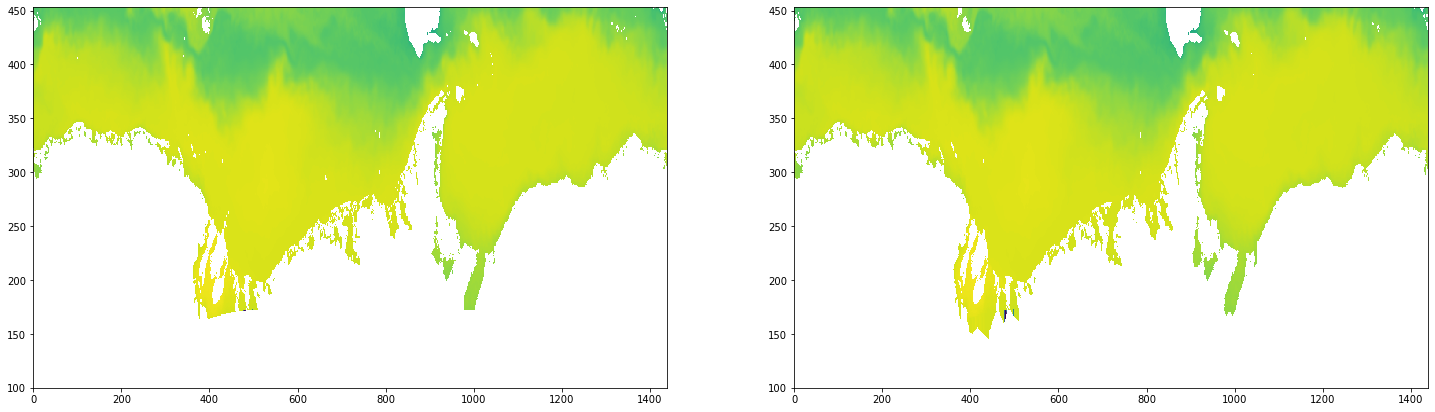

In [49]:
int=50
vminm=33
vmaxm=35
fig, ax = plt.subplots(1,2, figsize=(25,7))
ax[0].pcolormesh(SOSE_interp.SALT.isel(z=int).values, vmin=vminm, vmax=vmaxm)
ax[1].pcolormesh(theta_extended[int,:,:], vmin=vminm, vmax=vmaxm)

for axis in ax.ravel():
    axis.set_ylim(100,453)